In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import opening, closing, disk
from tqdm import tqdm  # for progress bars

In [ ]:
def load_band(image_path):
    """Load and normalize single band image with robust error handling"""
    try:
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise ValueError(f"Could not read image: {image_path}")
            
        # Normalize based on datatype
        if img.dtype == np.uint16:
            img = img.astype(np.float32) / 65535.0
        elif img.dtype == np.uint8:
            img = img.astype(np.float32) / 255.0
        else:
            img = img.astype(np.float32)
            
        return img
    except Exception as e:
        print(f"Error loading {image_path}: {str(e)}")
        return None


In [ ]:
def calculate_ndvi(nir_img, red_img):
    """Robust NDVI calculation with safety checks"""
    # Ensure images are same size
    if nir_img.shape != red_img.shape:
        raise ValueError("NIR and Red images must have the same dimensions")
    
    # Avoid division by zero
    denominator = (nir_img + red_img)
    denominator[denominator == 0] = 1e-10
    
    ndvi = (nir_img - red_img) / denominator
    return (ndvi + 1) / 2  # Scale to 0-1

In [ ]:
def create_vegetation_mask(ndvi):
    """Create optimized vegetation mask with post-processing"""
    # Adaptive thresholding
    block_size = int(min(ndvi.shape)/20)
    block_size = block_size + 1 if block_size % 2 == 0 else block_size
    adaptive_thresh = cv2.adaptiveThreshold(
        (ndvi*255).astype(np.uint8), 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        block_size, 
        -10
    )/255.0
    
    # Global thresholding
    global_thresh = ndvi > threshold_otsu(ndvi)
    
    # Combined mask
    mask = np.logical_and(global_thresh, adaptive_thresh)
    
    # Morphological operations
    kernel = disk(3)
    mask = opening(mask, kernel)  # Remove noise
    mask = closing(mask, kernel)  # Close small holes
    
    # Remove small objects
    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask.astype(np.uint8))
    sizes = stats[1:, -1]
    min_size = 25  # pixels
    clean_mask = np.zeros_like(mask)
    for i in range(n_labels - 1):
        if sizes[i] >= min_size:
            clean_mask[labels == i + 1] = 1
    
    return clean_mask.astype(np.uint8) * 255  # White=vegetation

In [ ]:
def process_folder_pair(nir_folder, red_folder, output_folder):
    """Process all matching NIR-Red pairs in folders"""
    os.makedirs(output_folder, exist_ok=True)
    
    # Get sorted lists of files
    nir_files = sorted([f for f in os.listdir(nir_folder) if f.lower().endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg'))])
    red_files = sorted([f for f in os.listdir(red_folder) if f.lower().endswith(('.tif', '.tiff', '.png', '.jpg', '.jpeg'))])
    
    # Verify we have matching pairs
    if len(nir_files) != len(red_files):
        print("Warning: Different number of files in NIR and Red folders")
    
    # Process each pair
    for nir_file, red_file in tqdm(zip(nir_files, red_files), total=min(len(nir_files), len(red_files))):
        try:
            # Load images
            nir_path = os.path.join(nir_folder, nir_file)
            red_path = os.path.join(red_folder, red_file)
            
            nir_img = load_band(nir_path)
            red_img = load_band(red_path)
            
            if nir_img is None or red_img is None:
                continue
                
            # Calculate NDVI and create mask
            ndvi = calculate_ndvi(nir_img, red_img)
            mask = create_vegetation_mask(ndvi)
            
            # Save mask (same name as input with _mask suffix)
            output_path = os.path.join(output_folder, os.path.splitext(nir_file)[0] + '_mask.png')
            cv2.imwrite(output_path, mask)
            
        except Exception as e:
            print(f"Error processing {nir_file} and {red_file}: {str(e)}")
            continue


In [ ]:
nir_folder = 'DATASET/NIR'
red_folder = 'DATASET/RED'
output_folder = 'DATASET/MASK2'

create_refined_ndvi_mask(nir_folder, red_folder, output_folder)

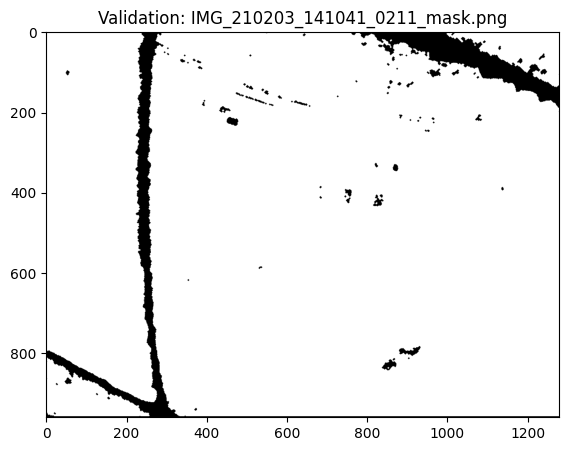

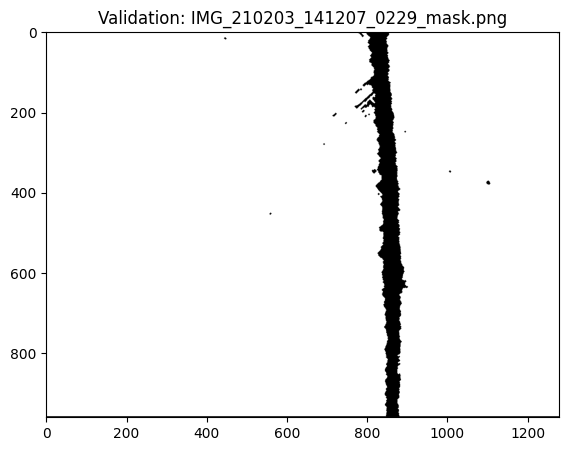

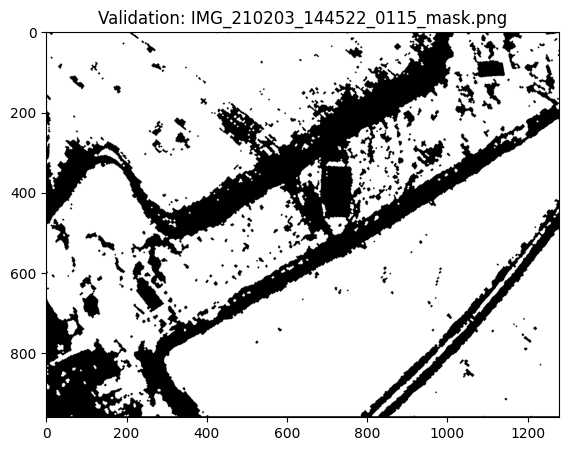

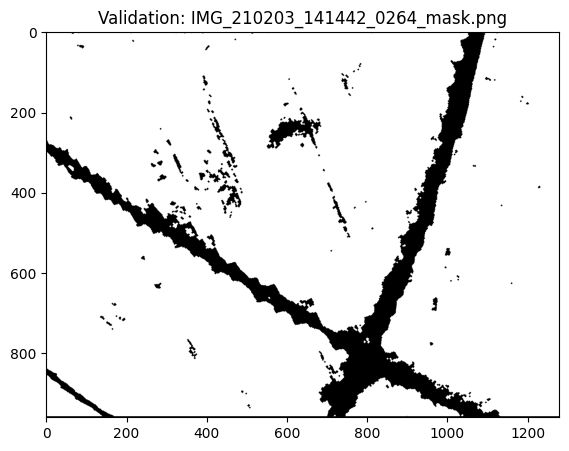

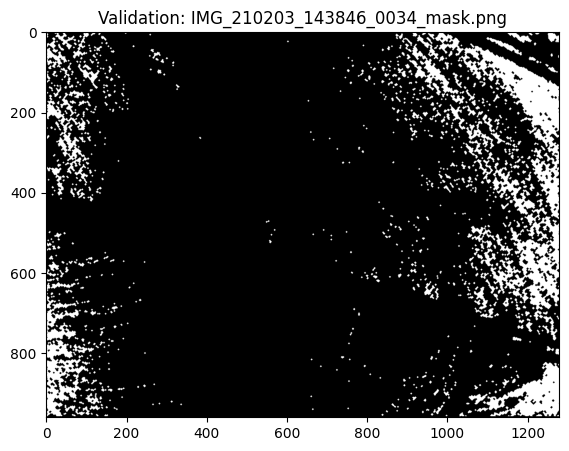

In [11]:
def validate_masks(mask_folder, sample_size=5):
    """Randomly check mask quality"""
    mask_files = [f for f in os.listdir(mask_folder) if f.endswith('.png')]
    samples = np.random.choice(mask_files, min(sample_size, len(mask_files)), replace=False)
    
    for mask_file in samples:
        mask = cv2.imread(os.path.join(mask_folder, mask_file), cv2.IMREAD_GRAYSCALE)
        plt.figure(figsize=(10,5))
        plt.imshow(mask, cmap='gray')
        plt.title(f"Validation: {mask_file}")
        plt.show()
validate_masks('DATASET/MASK2')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening, binary_closing
from skimage.morphology import disk

def create_refined_ndvi_mask(nir_folder, red_folder, output_folder, threshold=0.2, epsilon=1e-6):
    """
    Creates refined binary mask images from NIR and Red image pairs using NDVI,
    with noise removal for accurate vegetation (255) and non-vegetation (0) segmentation.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    nir_files = sorted([f for f in os.listdir(nir_folder) if os.path.isfile(os.path.join(nir_folder, f))])
    red_files = sorted([f for f in os.listdir(red_folder) if os.path.isfile(os.path.join(red_folder, f))])
    
    # Build dictionaries for matching by base name (without _NIR/_RED)
    nir_dict = {f.replace("_NIR", "").replace(".TIF", ""): f for f in nir_files}
    red_dict = {f.replace("_RED", "").replace(".TIF", ""): f for f in red_files}
    
    common_keys = set(nir_dict.keys()) & set(red_dict.keys())
    
    if not common_keys:
        raise ValueError("No matching NIR/Red pairs found!")
    
    for key in common_keys:
        nir_file = nir_dict[key]
        red_file = red_dict[key]
        
        nir_path = os.path.join(nir_folder, nir_file)
        red_path = os.path.join(red_folder, red_file)
        
        # Read images as float32
        nir = plt.imread(nir_path).astype(np.float32)
        red = plt.imread(red_path).astype(np.float32)
        
        if nir.ndim > 2: nir = nir[..., 0]
        if red.ndim > 2: red = red[..., 0]
        
        # NDVI calculation
        denominator = nir + red + epsilon
        ndvi = (nir - red) / denominator
        
        # Create initial binary mask
        mask = (ndvi > threshold).astype(np.uint8)
        
        # Morphological cleaning
        selem = disk(2)
        mask = binary_opening(mask, selem)
        mask = binary_closing(mask, selem)
        
        # Save mask (veg=255, non-veg=0)
        mask_img = mask * 255
        output_path = os.path.join(output_folder, key + "_mask.png")
        plt.imsave(output_path, mask_img, cmap="gray")
        
        print(f"✅ Saved refined mask for {key}")

# Example usage:
# create_refined_ndvi_mask("DATASET/NIR", "DATASET/RED", "DATASET/MASK2")


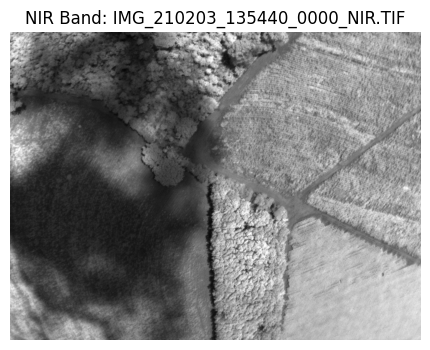

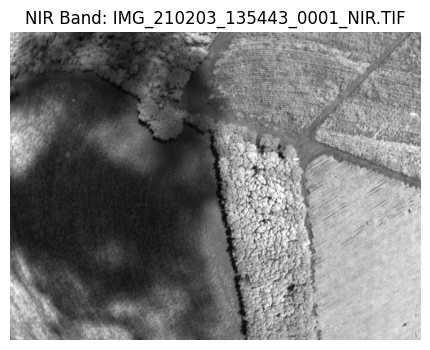

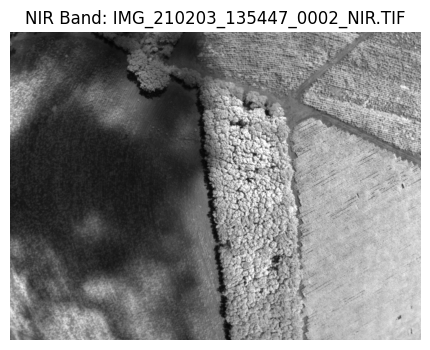

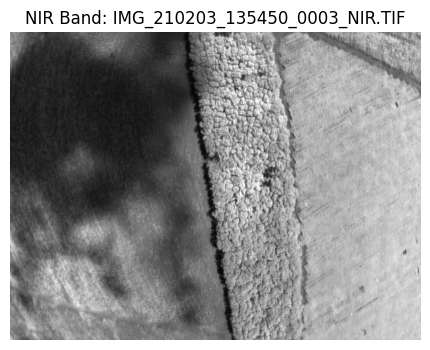

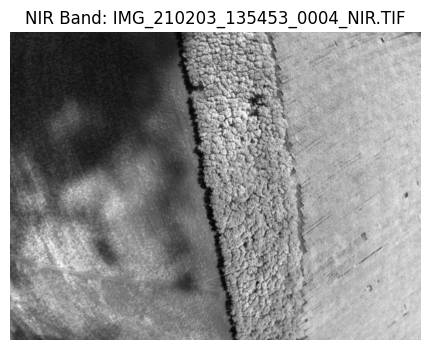

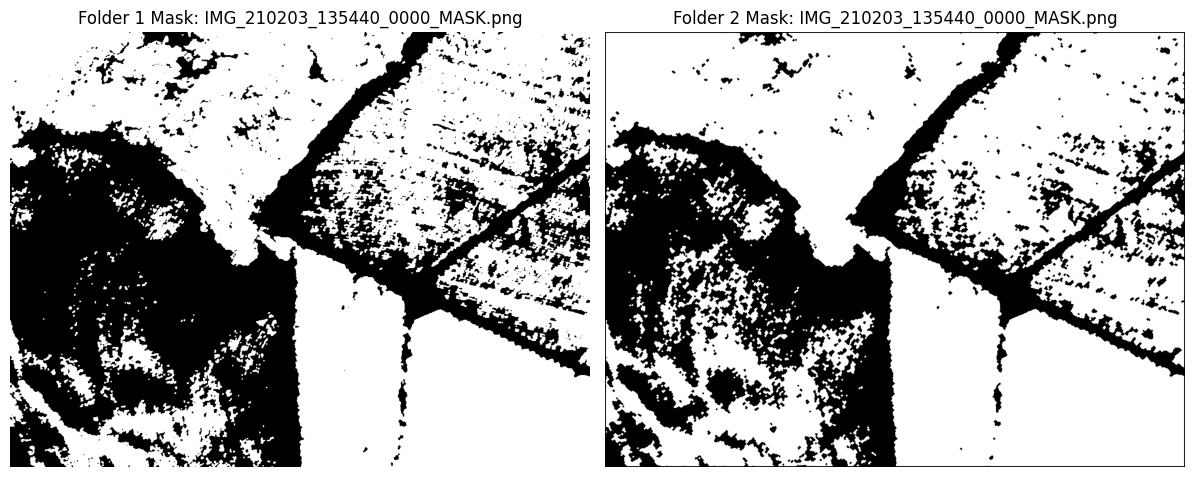

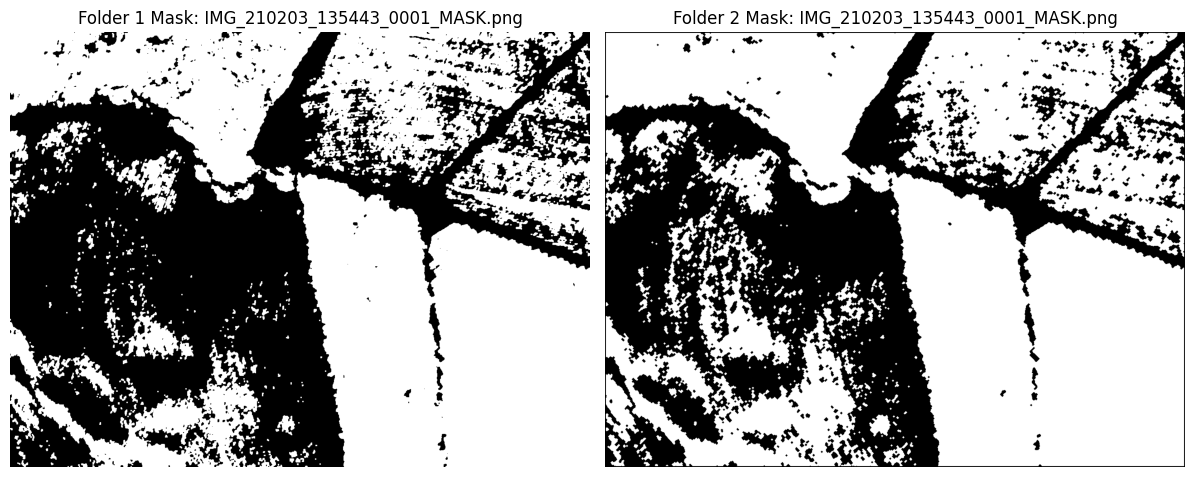

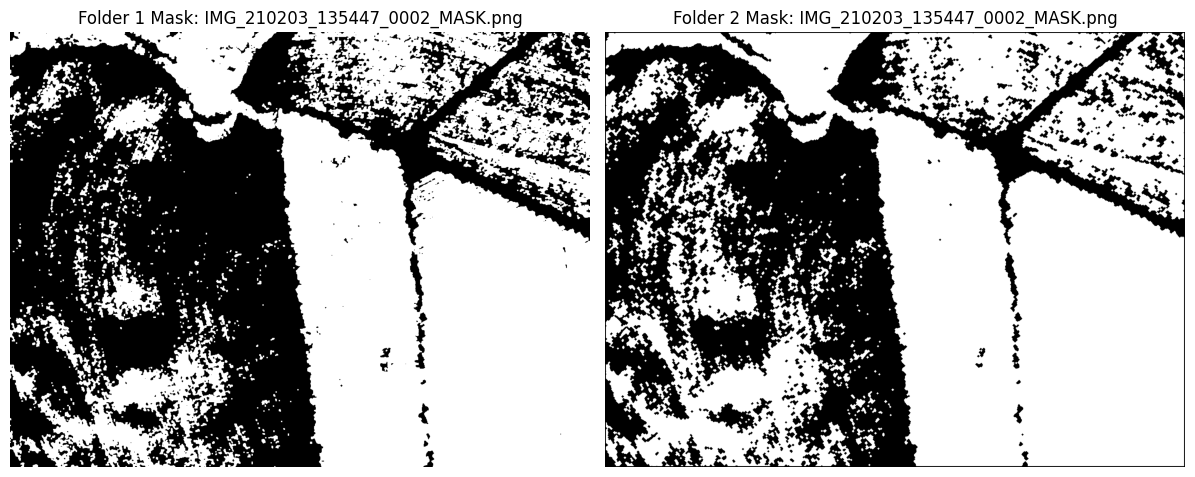

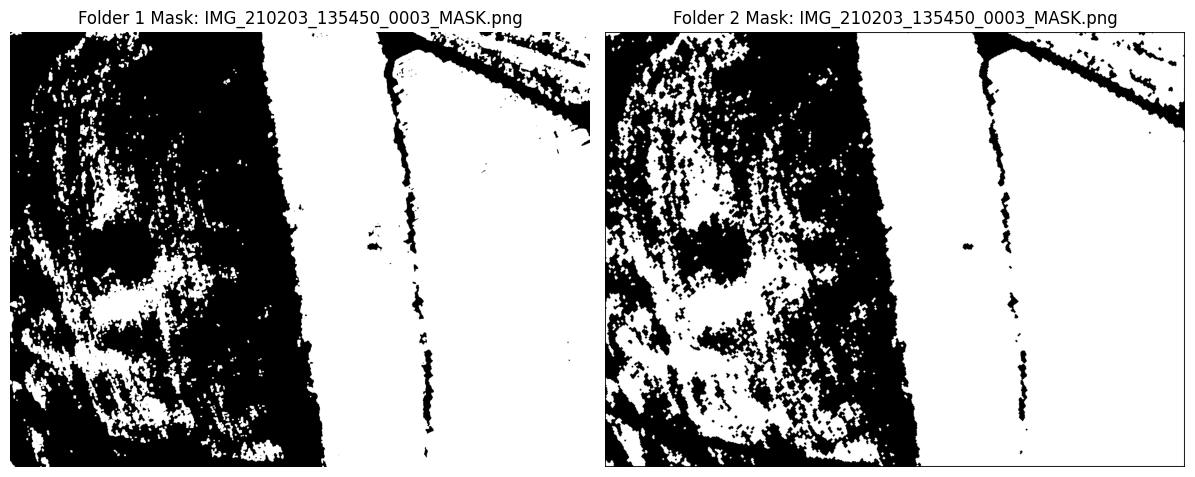

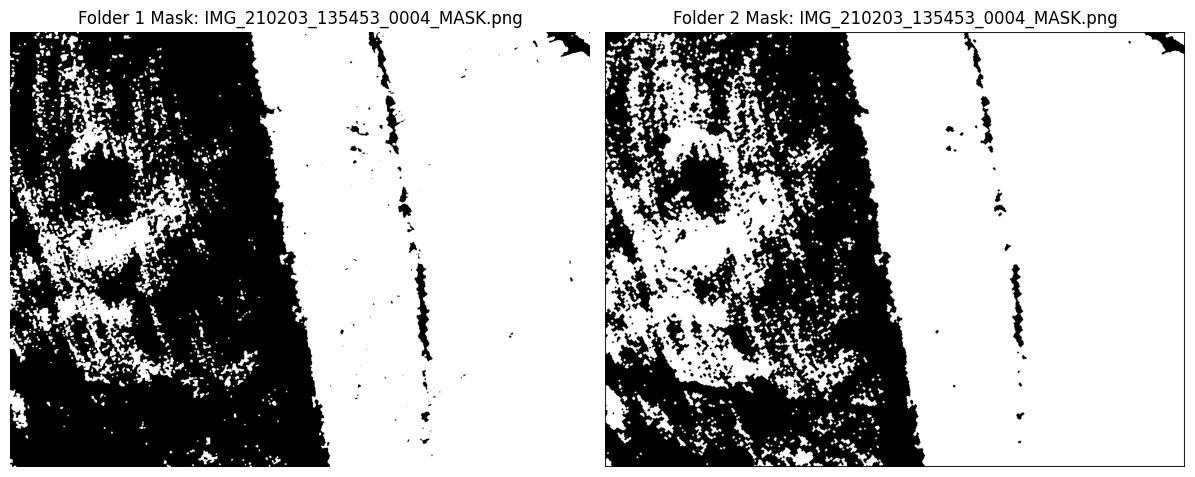

In [26]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

# Load images from Folder 1 and Folder 2
folder1_path = "DATASET/MASK"
folder2_path = "DATASET/MASK2"
nir_folder="DATASET/NIR"

for img_name in os.listdir(nir_folder)[:5]:
    nir_filename = img_name.replace("_mask.png", "_NIR.tif")
    nir_img = np.array(Image.open(os.path.join(nir_folder, img_name))) 
    plt.figure(figsize=(18, 6))
    
    # Subplot 1: Original NIR band
    plt.subplot(1, 3, 1)
    plt.imshow(nir_img, cmap='gray')
    plt.title(f"NIR Band: {img_name}")
    plt.axis('off')
    
    
# Compare first 5 images
for img_name in os.listdir(folder1_path)[:5]:
    # Load NIR band and masks
     # NIR band
    mask1 = np.array(Image.open(os.path.join(folder1_path, img_name)))   # Mask from Folder 1
    mask2 = np.array(Image.open(os.path.join(folder2_path, img_name)))   # Mask from Folder 2

    # Plot NIR + Masks
    plt.figure(figsize=(18, 6))
    # Subplot 2: Vegetation Mask from Folder 1
    plt.subplot(1, 3, 1)
    plt.imshow(mask1, cmap='gray')
    plt.title(f"Folder 1 Mask: {img_name}")
    plt.axis('off')

    # Subplot 3: Vegetation Mask from Folder 2
    plt.subplot(1, 3, 2)
    plt.imshow(mask2, cmap='gray')
    plt.title(f"Folder 2 Mask: {img_name}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()